## 1. 环境准备
- 建议使用 GPU 运行时 (Runtime -> Change runtime type -> GPU).

In [2]:
!nvidia-smi
!pip install --quiet --upgrade pip
# 强制安装 numpy<2 以兼容 torch 2.2.x
!pip install --quiet "numpy<2"
!pip install --quiet torch==2.2.2+cu121 torchvision==0.17.2+cu121 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu121
!pip install --quiet tqdm omegaconf matplotlib

Thu Nov 27 06:43:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   51C    P8             17W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Git 设置与仓库同步

In [ ]:
import getpass, os, subprocess

REPO_URL = "https://github.com/lachlanye/MLLM-from-scratch.git"
repo_name = REPO_URL.split("/")[-1].replace(".git", "")

# 1. 防止嵌套目录：检查当前是否已经在仓库目录中
if os.getcwd().endswith(repo_name):
    print(f"Already in {repo_name} directory.")
else:
    # 2. 如果不在，检查是否存在，不存在则克隆
    if not os.path.exists(repo_name):
        print(f"Cloning {repo_name}...")
        # 如果环境变量中没有 Token，交互式输入
        if "GITHUB_TOKEN" not in os.environ or not os.environ["GITHUB_TOKEN"]:
            print("Enter your GitHub Personal Access Token (input隐藏):")
            os.environ["GITHUB_TOKEN"] = getpass.getpass()
        clone_url = f"https://{os.environ['GITHUB_TOKEN']}@" + REPO_URL.split("https://")[-1]
        subprocess.run(["git", "clone", clone_url], check=True)
    
    # 3. 进入目录
    %cd $repo_name

# 4. 配置 Git
!git config user.name "lachlanye"
!git config user.email "colab@example.com"

# 5. 拉取代码 (使用 master 分支)
!git pull origin master

/content/MLLM-from-scratch
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 656 bytes | 656.00 KiB/s, done.
From https://github.com/lachlanye/MLLM-from-scratch
 * branch            master     -> FETCH_HEAD
   c218e73..96a3132  master     -> origin/master
Updating c218e73..96a3132
Fast-forward
 datasets/tinyshakespeare.py | 14 +++++++++++---
 1 file changed, 11 insertions(+), 3 deletions(-)
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 656 bytes | 656.00 KiB/s, done.
From https://github.com/lachlanye/MLLM-from-scratch
 * branch            master     -> FETCH_HEAD
   c218e73..96a3132  master     -> origin/master
Updating c218e73.

## 3. 数据集准备
加载 Tiny Shakespeare 数据集并查看部分数据。

In [4]:
from datasets.tinyshakespeare import TinyShakespeareDataset
import torch

# 初始化数据集 (会自动下载)
dataset = TinyShakespeareDataset(root="data", download=True)
print(f"Vocab size: {dataset.vocab_size}")
print(f"Dataset length: {len(dataset)}")

# 查看前 200 个字符
print("\n--- Data Sample ---")
print(dataset.tokenizer.decode(dataset.data[:200].tolist()))
print("-------------------")

File already exists at data/tinyshakespeare/input.txt, skipping download.
Found existing vocabulary at data/tinyshakespeare/vocab.json. Loading...
Vocabulary loaded from data/tinyshakespeare/vocab.json
Encoding the entire corpus into a single sequence...
Corpus successfully encoded. Total characters (tokens): 1115394
Vocab size: 69
Dataset length: 8713

--- Data Sample ---
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you
-------------------


## 4. 训练配置
查看当前的训练配置 `configs/llm_config.yaml`。

In [5]:
import yaml
from pathlib import Path

config_path = Path("configs/llm_config.yaml")
with open(config_path) as f:
    config = yaml.safe_load(f)
    
# 可以在这里动态修改配置，例如增加 epoch
# config['training_params']['num_epochs'] = 5
# with open(config_path, 'w') as f:
#     yaml.dump(config, f)

print(yaml.dump(config))

data_params:
  block_size: 256
  data_dir: data
  dataset_path: ./data/tinyshakespeare/input.txt
  dataset_url: https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
generation_params:
  max_new_tokens: 500
  start_context: You are all resolved
model_params:
  d_ff: 1536
  d_model: 384
  dropout: 0.1
  n_heads: 6
  num_layers: 6
  vocab_size: 65
training_params:
  batch_size: 64
  device: cuda
  eval_interval: 1
  learning_rate: 0.0003
  model_save_path: checkpoints/llm_tinyshakespeare.pth
  num_epochs: 10
  num_workers: 4
  weight_decay: 0.01



## 5. 开始训练
运行 `language_model/train_llm.py`。我们将输出重定向到日志文件以便后续绘图。

In [6]:
# 确保保存目录存在
!mkdir -p checkpoints
# 运行训练并将输出同时显示在控制台和保存到 training.log
!python -m language_model.train_llm | tee training.log

Configuration loaded successfully.
Random seed set to 42
Using device: cuda
File already exists at data/tinyshakespeare/input.txt, skipping download.
Found existing vocabulary at data/tinyshakespeare/vocab.json. Loading...
Vocabulary loaded from data/tinyshakespeare/vocab.json
Encoding the entire corpus into a single sequence...
Corpus successfully encoded. Total characters (tokens): 1115394
Epoch 1/10 [Train]: 100% 62/62 [00:14<00:00,  4.15it/s, loss=2.51]
Epoch 1/10 [Train]: 100% 62/62 [00:14<00:00,  4.15it/s, loss=2.51]
Epoch 1/10 [Eval]: 100% 7/7 [00:00<00:00, 11.12it/s]
Epoch 1/10 [Eval]: 100% 7/7 [00:00<00:00, 11.12it/s]

Epoch 1/10 Summary | Train Loss: 2.7676 | Val Loss: 2.5111

--- Generating Sample Text ---
O Romeo, Romeo! wherefore art thouthe te ourou stalo d memelt hantelld t, od owhed ntes y whoucQwale h dta whithamyI winone I'de we thoo'theledkld out bel tI hames bl de Nouuthisthesor
--- End of Sample ---

New best model saved to checkpoints/llm_tinyshakespeare.pth with 

## 6. 训练过程可视化 (Loss Curve)
解析 `training.log` 并绘制训练和验证 Loss 曲线。

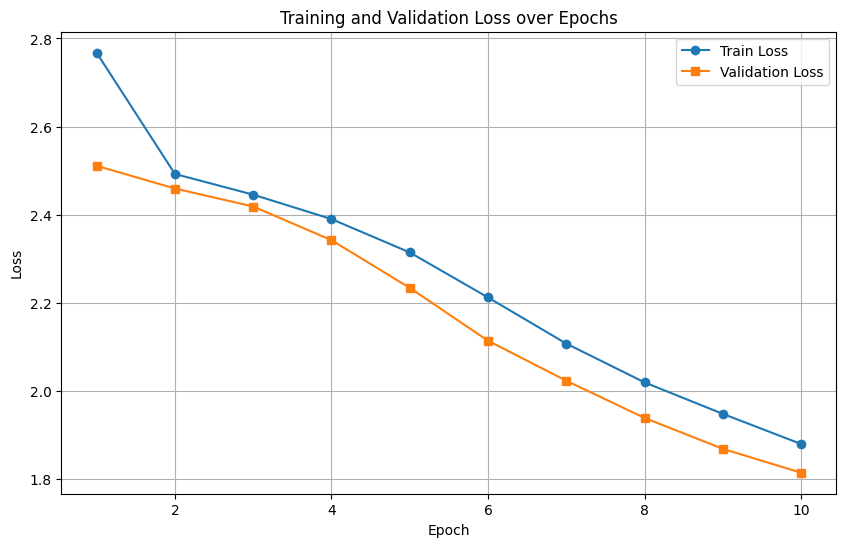

In [7]:
import matplotlib.pyplot as plt
import re

train_losses = []
val_losses = []
epochs = []

# 解析日志文件
with open("training.log", "r") as f:
    for line in f:
        # 匹配格式: Epoch 1/10 Summary | Train Loss: 2.5000 | Val Loss: 2.4000
        match = re.search(r"Epoch (\d+)/\d+ Summary \| Train Loss: ([\d\.]+) \| Val Loss: ([\d\.]+)", line)
        if match:
            epochs.append(int(match.group(1)))
            train_losses.append(float(match.group(2)))
            val_losses.append(float(match.group(3)))

if not epochs:
    print("未找到训练日志数据，请检查训练是否成功完成。")
else:
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

## 7. 文本生成展示
使用训练好的模型生成莎士比亚风格的文本。

In [8]:
# 样本 1
!python -m language_model.generate_text

### 结果分析与对比
请观察上方生成的文本，并与第 3 节中的原始数据进行对比：
1. **格式**: 模型是否学会了剧本的格式（如角色名大写、换行、缩进）？
2. **拼写**: 单词拼写是否基本正确？
3. **风格**: 是否有古英语的韵味（如 thou, art, hath 等词的使用）？

虽然模型较小且训练时间短，但它应该能捕捉到莎士比亚风格的“形似”。

In [9]:
# 样本 2 (修改 configs/llm_config.yaml 中的 start_context 来生成不同的文本)
import yaml

# 读取配置
with open("configs/llm_config.yaml", 'r') as f:
    cfg = yaml.safe_load(f)

# 修改起始文本
cfg['generation_params']['start_context'] = "To be, or not to be"

# 写入临时配置
with open("configs/llm_config_sample2.yaml", 'w') as f:
    yaml.dump(cfg, f)

# 使用新配置生成
# 注意：generate_text.py 默认读取 configs/llm_config.yaml，我们需要修改代码或覆盖文件
# 这里简单起见，我们直接覆盖原配置文件，生成后再改回来 (或者修改 generate_text.py 接受参数)
# 为了演示，我们直接覆盖
with open("configs/llm_config.yaml", 'w') as f:
    yaml.dump(cfg, f)

print("--- Sample 2: 'To be, or not to be' ---")
!python -m language_model.generate_text

# 恢复配置 (可选)
cfg['generation_params']['start_context'] = "You are all resolved"
with open("configs/llm_config.yaml", 'w') as f:
    yaml.dump(cfg, f)

--- Sample 2: 'To be, or not to be' ---


## 8. 保存结果
将训练好的模型和日志推送到 GitHub。

In [10]:
!git status
!git add -f checkpoints/llm_tinyshakespeare.pth training.log
!git commit -m "Add LLM training results and logs" || echo "Nothing to commit"
!git push origin master

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   configs/llm_config.yaml
	modified:   transformer_from_scratch/__pycache__/__init__.cpython-312.pyc
	modified:   transformer_from_scratch/__pycache__/attention.cpython-312.pyc
	modified:   transformer_from_scratch/__pycache__/blocks.cpython-312.pyc
	modified:   transformer_from_scratch/__pycache__/layers.cpython-312.pyc
	modified:   transformer_from_scratch/__pycache__/model.cpython-312.pyc

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	checkpoints/
	configs/llm_config_sample2.yaml
	data/
	training.log

no changes added to commit (use "git add" and/or "git commit -a")
[master a4b997a] Add LLM training results and logs
 2 files changed, 136 insertions(+)
 create mode 100644 checkpoints/llm_tinyshakespeare.pth
 cr

In [12]:
!git pull origin master

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 414 bytes | 414.00 KiB/s, done.
From https://github.com/lachlanye/MLLM-from-scratch
 * branch            master     -> FETCH_HEAD
   96a3132..d24378c  master     -> origin/master
hint: You have divergent branches and need to specify how to reconcile them.
hint: You can do so by running one of the following commands sometime before
hint: your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured de